In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

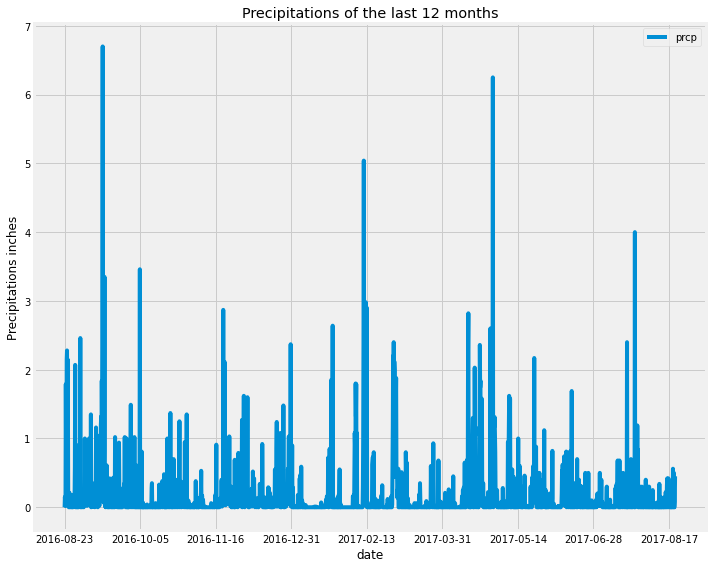

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
from datetime import datetime as dtt
query_date = dtt.strptime(session.query(func.max(Measurement.date)).\
                first()[0], '%Y-%m-%d') - dt.timedelta(days=365)
date = dtt.strftime(query_date,'%Y-%m-%d')

prcp_lastyear = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date>=date).order_by('date').all()
df_prcp = pd.DataFrame(prcp_lastyear).set_index('date')
df_prcp.dropna().plot.line(figsize=(10,8),title='Precipitations of the last 12 months',ylabel='Precipitations inches')
plt.tight_layout()
plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data)
df_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct
print(f"There are {session.query(func.count(distinct(Measurement.station))).first()[0]} stations in the data set")

There are 9 stations in the data set


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
con = engine.connect()
active_stations = session.query(Measurement.station,Station.name,func.count(Measurement.prcp)).\
    filter(Station.station == Measurement.station).\
    group_by('station').order_by(func.count(Measurement.prcp).desc()).statement
stations_df = pd.read_sql_query(active_stations,con)
stations_df = stations_df.rename({'count_1':'activity'}, axis=1).dropna()
stations_df

,station,name,activity
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00513117,"KANEOHE 838.1, HI US",2696
2,USC00519397,"WAIKIKI 717.2, HI US",2685
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2484
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,USC00517948,"PEARL CITY, HI US",683
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",342


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded,# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]
stm = session.query(*sel).filter_by(station = 'USC00519281').statement
df_tobs_ext = pd.read_sql_query(stm,con)
df_tobs_ext.rename({'min_1':'min','max_1':'max','avg_1':'avg'},axis=1, inplace=True)
df_tobs_ext

,station,min,max,avg
0,USC00519281,54.0,85.0,71.663781


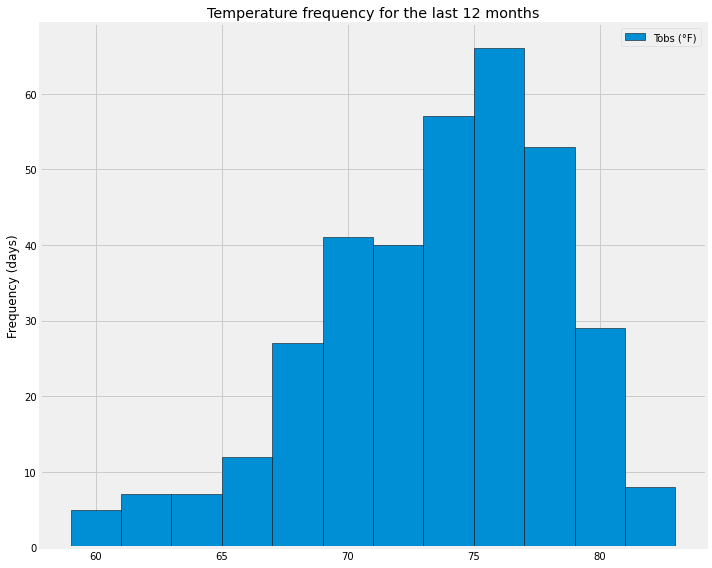

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_station = session.query(Measurement.station,func.count(Measurement.tobs)).\
        group_by('station').order_by(func.count(Measurement.tobs).desc()).first()[0]
stm = session.query(Measurement.date,Measurement.tobs).\
    filter_by(station = query_station).\
        filter(Measurement.date >= date).\
            order_by('date').statement
tobs_df = pd.read_sql_query(stm,con)
tobs_df = tobs_df.rename({'tobs':'Tobs (°F)'},axis=1).set_index('date')
hist = tobs_df.plot.hist(title='Temperature frequency for the last 12 months',figsize=(10,8),edgecolor='black',bins=12)
hist.set_ylabel('Frequency (days)')
plt.tight_layout()

## Bonus Challenge Assignment

### Temperature Analysis I
* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
* You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.
* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
* Use the t-test to determine whether the difference in the means, if any, is statistically significant.


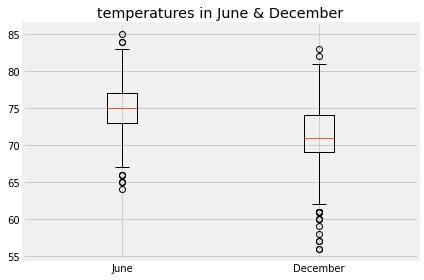

In [15]:
temp_ju = session.query(Measurement.tobs).\
    filter(func.strftime('%m', Measurement.date)== '06').all()
temp_dec = session.query(Measurement.tobs).\
    filter(func.strftime('%m', Measurement.date)== '12').all()
dec = [t[0] for t in temp_dec]
ju = [t[0] for t in temp_ju]
xticks = ['June','December']
plt.boxplot([ju,dec])
plt.title('temperatures in June & December')
plt.xticks(ticks=[1,2],labels=xticks)
plt.tight_layout()

In [16]:
from scipy import stats
stats.ttest_ind(ju, dec)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

### Temperature Analysis II

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# retrieve the different year
trip_start_date = '2020-12-15'
trip_end_date = '2020-12-31'
years = list(np.ravel(session.query(func.strftime("%Y", Measurement.date)).\
    group_by(func.strftime("%Y", Measurement.date)).all()))
# use the function to calculate the temperature for every year with data and store in the temps list
temps = []
for year in years:
    temps.append(list(np.ravel(calc_temps(
        trip_start_date.replace('2020',str(year)),trip_end_date.replace('2020',str(year))))))

In [19]:
# calculate the average for the 7 years of data
## nothing in 2017 as it stops earlier than the dates chosen
min_temps = np.mean([t[0] for t in temps if t[0] != None])
avg_temps = np.mean([t[1] for t in temps if t[1] != None])
max_temps = np.mean([t[2] for t in temps if t[2] != None])

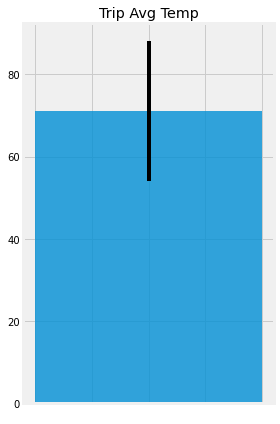

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = avg_temps
err = max_temps-min_temps

plt.figure(figsize=(4,6))
ax = plt.bar(1,y,yerr=err,alpha=0.8,align='center')
plt.title("Trip Avg Temp")
plt.xticks(c = 'w')
plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Avg calculation for the last 8 year with data, not just one
sel = [Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.sum(Measurement.prcp)/len(years)]
stm = session.query(*sel).\
    filter(Measurement.station == Station.station).\
        filter(func.strftime('%m-%d',Measurement.date)>='12-15').\
            filter(func.strftime('%m-%d',Measurement.date)<='12-31').\
                group_by(Station.name).\
                    order_by((func.sum(Measurement.prcp)/len(years)).desc()).statement
rainfall_df = pd.read_sql_query(stm,con)
rainfall_df.rename({'anon_1':'Total rainfall'},axis=1,inplace=True)
rainfall_df

,name,latitude,longitude,elevation,Total rainfall
0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,7.34250
1,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.13500
2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.45500
3,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.60500
4,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,1.95000
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.52125
6,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.86125
7,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.05875
8,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.03875


### Daily Temp Average

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = {}
for day in range(15,32):
    normals[f'2020-12-{day}']=np.ravel((daily_normals(f'12-{day}')))

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals).T
daily_normals_df.rename({0:'min',1:'avg',2:'max'},axis=1,inplace=True)
daily_normals_df

,min,avg,max
2020-12-15,62.0,71.340000,79.0
2020-12-16,60.0,69.622642,82.0
2020-12-17,63.0,70.640000,77.0
2020-12-18,63.0,71.280000,77.0
2020-12-19,67.0,72.000000,78.0
2020-12-20,65.0,72.913043,81.0
2020-12-21,67.0,72.139535,78.0
2020-12-22,67.0,71.130435,77.0
2020-12-23,61.0,70.346939,78.0
2020-12-24,62.0,70.062500,78.0


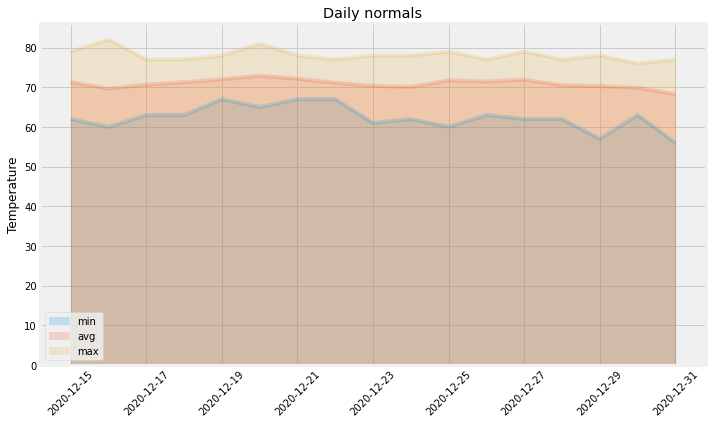

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(stacked=False,title='Daily normals',ylabel='Temperature', figsize=(10,6),alpha=0.2)
plt.xticks(rotation=45)
plt.legend(loc=('lower left'))
plt.tight_layout()
plt.savefig("Images/Daily_normals.png",transparent=True)